# Get 1D mass from fit to sbp extrapolated 

I am fitting between 50 and 100kpc and then extrapolating to 500kpc, integrating from 100 to 500 to get the mass and then adding that to the mass at 100kpc given by galSBP. I did 2 fits: a power law fit to mu and r in linear space, and a linear fit in log-log space. I realize it’s essentially the same thing, with an additional parameter in the power law fit, but I thought it would be good to compare. The power law fit better recovers the total mass from the galSBP measurement, so I will use that one. I just wanted to make sure that I am doing it correctly.

In [1]:
import numpy as np
import sep
import h5py
import fitsio
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import glob

from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.interpolate import interp1d

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [2]:
#interpolated 1D mass
def oneD_mass(galaxy_iso, radius):
    mass=np.interp(radius,galaxy_iso['sma_kpc'], galaxy_iso['growth_ori'])
    return np.log10(mass)

In [2]:
#open pickels
illustris_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_quick.pkl'
illustris_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_isos_quick.pkl'

tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_quick.pkl'
tng_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_quick.pkl'

def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

illustris_masses = open_pkl(illustris_masses_file)
tng_masses = open_pkl(tng_masses_file)
illustris_isos = open_pkl(illustris_isos_file)
tng_isos = open_pkl(tng_isos_file)

In [3]:
pixel_scale=2.*800./300 #kpc/pixel
print 'pixel scale: ', pixel_scale

pixel scale:  5.33333333333


In [4]:
iso=illustris_isos[0]

Text(0.5,0,u'$\\mathrm{SMA/kpc}$')

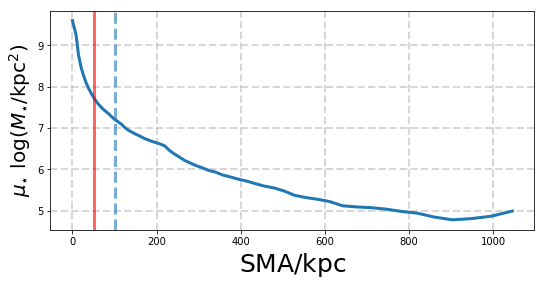

In [6]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(2, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)

ax1.plot((iso['sma_kpc']), 
         np.log10(iso['intens_kpc']), linewidth=3.0)

ax1.set_ylabel(r'$\mu_{\star}\ \log(M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(50, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
#ax1.set_xlim(0, 300)
ax1.set_xlabel(r'$\mathrm{SMA/kpc}$', fontsize=25)


# fit power law between 50 and 100 kpc 

In [34]:
x=iso['sma_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
y=iso['intens_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]

In [15]:
# def powerlaw(x, m, c, c0):
#     return c0 + x**m * c

# p_fit_power, _ = curve_fit(powerlaw, x, y, p0=[-2,10**10,0])
# p_fit_power

array([ -1.86124869e+00,   7.66511164e+10,   2.63777269e+06])

In [74]:
def powerlaw(x, m, c):
    return x**m * c

In [12]:
p_fit_power, _ = curve_fit(powerlaw, x, y, p0=[-2,10**10])
p_fit_power

NameError: name 'x' is not defined

#### linear 

Text(0.5,0,u'$\\mathrm{SMA/kpc}$')

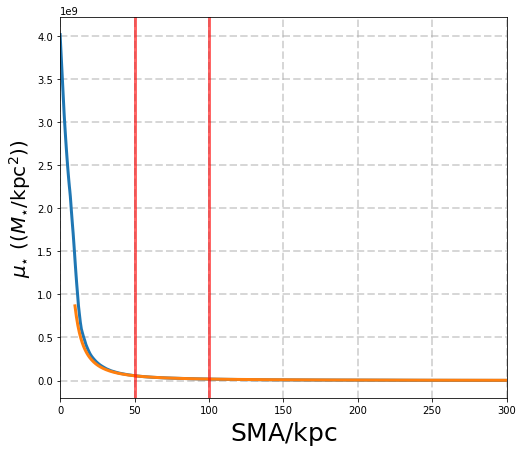

In [22]:
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

plt.plot((iso['sma_kpc']), iso['intens_kpc'], linewidth=3.0)

x=np.linspace(10,300,600)
plt.plot(x, powerlaw(x,*p_fit_power), linewidth=3.0)

plt.ylabel(r'$\mu_{\star}\ ((M_{\star}/\mathrm{kpc}^2))$', fontsize=20)
plt.axvline(100.0, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.axvline(50, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.xlim(0, 300)
plt.xlabel(r'$\mathrm{SMA/kpc}$', fontsize=25)

#### log 

Text(0.5,0,u'$\\mathrm{SMA/kpc}$')

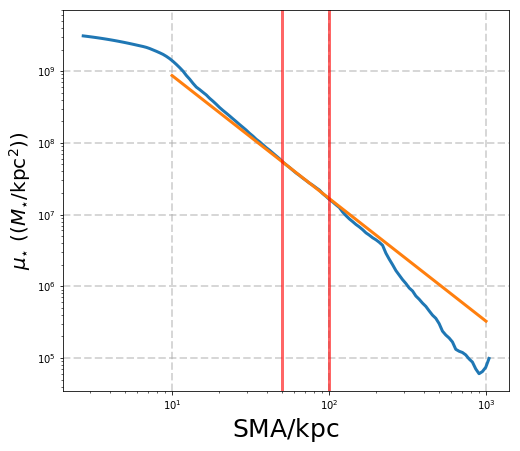

In [23]:
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

plt.loglog((iso['sma_kpc']), iso['intens_kpc'], linewidth=3.0)

x=np.linspace(10,1000,600)
plt.loglog(x, powerlaw(x,*p_fit_power), linewidth=3.0)

plt.ylabel(r'$\mu_{\star}\ ((M_{\star}/\mathrm{kpc}^2))$', fontsize=20)
plt.axvline(100.0, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.axvline(50, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
#plt.xlim(0, 300)
plt.xlabel(r'$\mathrm{SMA/kpc}$', fontsize=25)

# plots to show extrapolations 

In [9]:
def mu_fit(iso, pixel_scale):
    return 10**(np.log10(iso['intens'] / (pixel_scale**2.0))+ np.log10(0.7 ** 2.0))
def mu_extrap(iso):
    return 10**(fit_power_law(iso)+ np.log10(0.7 ** 2.0))

def fit_power_law(iso):
    
    x=iso['sma_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    y=iso['intens_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    
    p_fit_power, _ = curve_fit(powerlaw, x, y, p0=[-2,10**10])
    
    return np.log10(powerlaw(iso['sma_kpc'],*p_fit_power))


In [10]:
nbin=150
def get_median_profile(isos, pixel_scale, quantity = 'intens', rmin=0.05, rmax=4.7, nbin=nbin):
    """Get the median profiles."""
    sma_common = np.linspace(rmin, rmax, nbin)
    
    if quantity == 'intens':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25, 
                                               np.log10(gal[quantity] / (pixel_scale ** 2)),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(sma_common) 
                               for gal in isos]), axis=0)
    elif quantity == 'growth_ori':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25, 
                                               np.log10(gal[quantity]),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(sma_common) 
                               for gal in isos]), axis=0)
    elif quantity == 'ratio':
        
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25, 
                                               mu_extrap(gal)/mu_fit(gal, pixel_scale),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(sma_common) 
                               for gal in isos]), axis=0)

    return sma_common, mu


/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


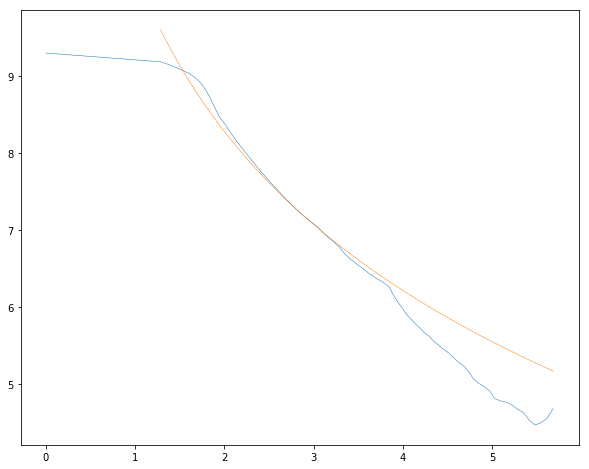

In [57]:
plt.plot((iso['sma'] * pixel_scale) ** 0.25, np.log10(iso['intens'] / (pixel_scale**2.0))+ np.log10(0.7 ** 2.0) , linewidth=0.5, alpha=1, 
                 label='_nolegend_', zorder=1)

plt.plot((iso['sma'] * pixel_scale) ** 0.25, fit_power_law(iso)+ np.log10(0.7 ** 2.0) , linewidth=0.5, alpha=1, 
                 label='_nolegend_', zorder=1)

plt.show()

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


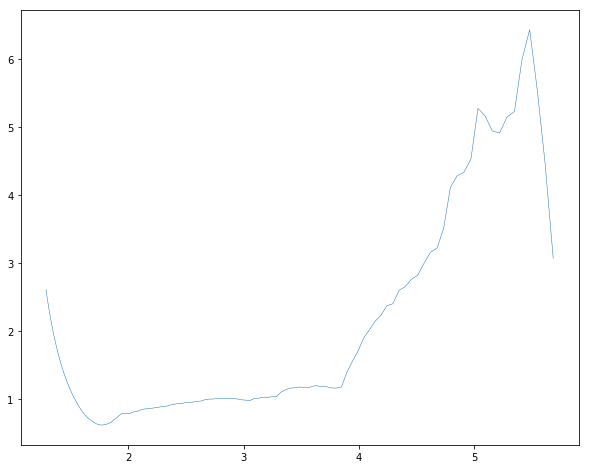

In [58]:
mu_fit =  10**(np.log10(iso['intens'] / (pixel_scale**2.0))+ np.log10(0.7 ** 2.0))
mu_extrap = 10**(fit_power_law(iso)+ np.log10(0.7 ** 2.0))
ratio = mu_extrap / mu_fit

plt.plot((iso['sma'] * pixel_scale) ** 0.25, ratio , linewidth=0.5, alpha=1, label='_nolegend_', zorder=1)
plt.show()

## mu ratios

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in divide
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in divide


339


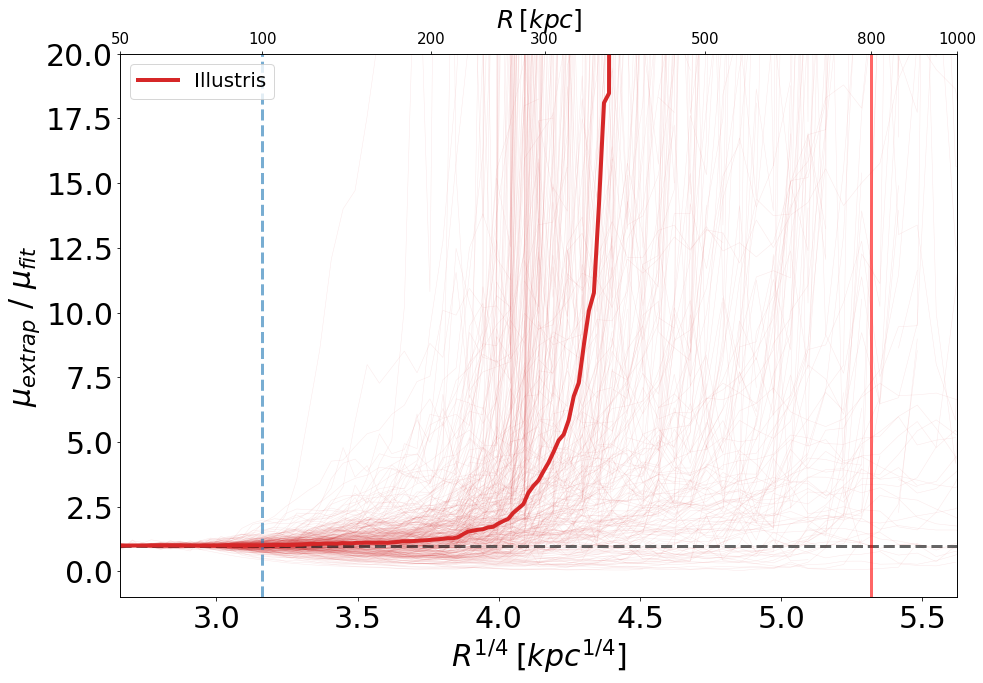

In [91]:
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()


######################################################################################################################
# plot
######################################################################################################################

for iso in illustris_isos:   
    

        ngals1+=1
        
        #calculate ratio of mus
        ratio = mu_extrap(iso) / mu_fit(iso, pixel_scale)

        ax1.plot((iso['sma'] * pixel_scale) ** 0.25, ratio , linewidth=0.5, c=u'#d62728', alpha=0.1, 
                 label='_nolegend_', zorder=1)
                 #label='Illustris Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))


## median profiles for illustris
median_sma1, median_mu1 = get_median_profile(illustris_isos, quantity = 'ratio',
                                             pixel_scale = pixel_scale, rmin=50**0.25, rmax=800.**0.25)

ax1.plot(median_sma1, median_mu1, linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris', zorder=8)


print ngals1


# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
ax1.set_xlim(50**0.25, 1000**0.25)
ax1.set_ylim(-1, 20)

# Labels
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{extrap} \ / \ \mu_{fit} $', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axhline(1., linestyle='--', linewidth=3.0, alpha=0.6, c='k', zorder=1)

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_Illustris.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

# pick 5 random, and plot profile + the extrapolated line 

In [90]:
#pick 5 random
random_indices = np.random.choice(range(len(illustris_isos)), 5, replace=False)
random_isos = [illustris_isos[i] for i in random_indices]
random_masses = [illustris_masses[i] for i in random_indices]

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in divide


5


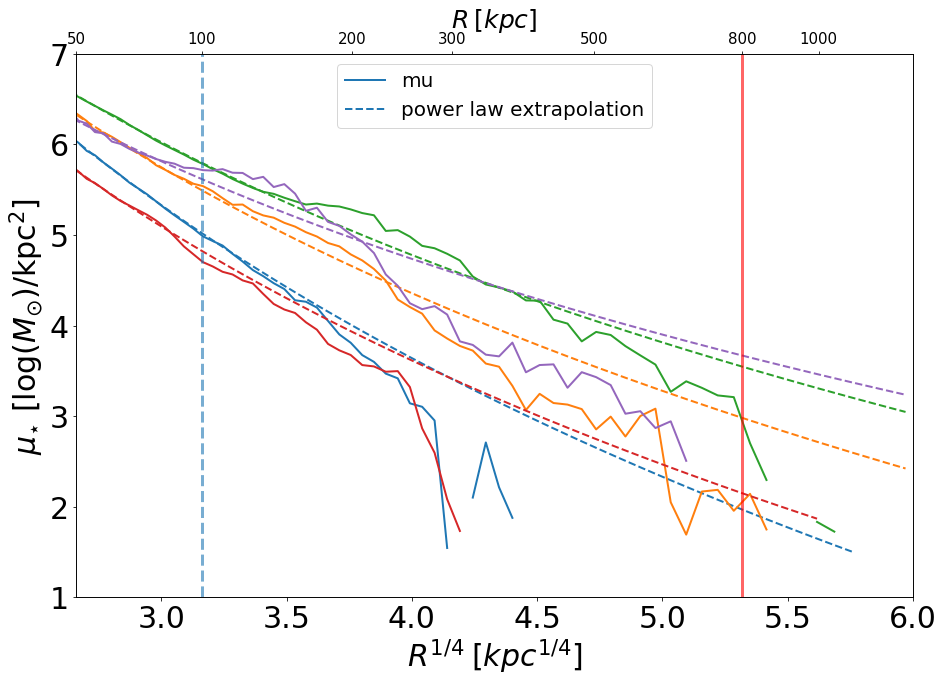

In [91]:
#plot
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()


######################################################################################################################
# plot
######################################################################################################################

for iso in random_isos:   
    
        ngals1+=1
        
        mu_plot = ax1.plot((iso['sma'] * pixel_scale) ** 0.25, np.log10(mu_fit(iso, pixel_scale)), linewidth=2, 
                           alpha=1, label='mu', zorder=1)
        ax1.plot((iso['sma'] * pixel_scale) ** 0.25, np.log10(mu_extrap(iso)), linewidth=2, linestyle='--',
                 alpha=1, c=mu_plot[0].get_color(), label='power law extrapolation', zorder=1)
                 


## median profiles for illustris
median_sma1, median_mu1 = get_median_profile(illustris_isos, quantity = 'ratio',
                                             pixel_scale = pixel_scale, rmin=50**0.25, rmax=800.**0.25)

#ax1.plot(median_sma1, median_mu1, linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris', zorder=8)


print ngals1


# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
ax1.set_xlim(50**0.25, 6)
ax1.set_ylim(1, 7)

# Labels
ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2], labels[:2], fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
#ax1.set_title('5 randomly selected profiles and extrapolations', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_Illustris.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## check mass

In [118]:
def oneD_mass(galaxy_iso, radius):
    mass=np.interp(radius,galaxy_iso['sma_kpc'], galaxy_iso['growth_ori'])
    return np.log10(mass)
def powerlaw2(x, m, c, c0):
    return c0 + x**m * c
def power_law_r2(x, m, c, c0):
    return powerlaw2(x, m, c, c0)*x

def extrapolated_1D_mass2(iso, max_r):

    #fit power law between 50 and 100kpc
    x=iso['sma_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    y=iso['intens_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    p_fit_power, _ = curve_fit(powerlaw2, x, y, p0=[-2,10**10,0])
    #p_fit_power = [-2,10**10,0]

    #print p_fit_power

    #integrate between 100 and 500kpc to get mass
    mass_beyond100, mass_err =quad(power_law_r2, 100, max_r, args=tuple(p_fit_power))

    #add to galSBP mass to get total mass
    mass_100 = 10**(oneD_mass(iso, 100))
    power_law_fit_mass = np.log10(mass_100+mass_beyond100)

    return power_law_fit_mass

######################
#power law 1: without constant
def powerlaw1(x, m, c):
    return x**m * c
def power_law_r1(x, m, c):
    return powerlaw1(x, m, c)*x

def extrapolated_1D_mass1(iso, max_r):

    #fit power law between 50 and 100kpc
    x=iso['sma_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    y=iso['intens_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    p_fit_power, _ = curve_fit(powerlaw1, x, y, p0=[-2,10**10])
    #p_fit_power = [-2,10**10]

    #print p_fit_power

    #integrate between 100 and 500kpc to get mass
    mass_beyond100, mass_err =quad(power_law_r1, 100, max_r, args=tuple(p_fit_power))

    #add to galSBP mass to get total mass
    mass_100 = 10**(oneD_mass(iso, 100))
    power_law_fit_mass = np.log10(mass_100+mass_beyond100)

    return power_law_fit_mass

In [121]:
for iso in illustris_isos:
#     print '############1!!!!!!!!!!!!!!!!!'
    print extrapolated_1D_mass1(iso, 800) 
#     print '!!!!!!!!!!!!!!2###############'
#     print extrapolated_1D_mass2(iso, 800)

12.3067777298
12.0733503102
12.3151520544
12.1989818939
11.9462303831
11.9127078223
12.1189103045
12.0336323359
12.0967811202
12.0665045328
12.1624309951
11.8300914845
11.7542336568
11.9210838494
11.7209442948
11.4087852915
11.9208886394
11.570238011
11.3966475956
11.7992961516
11.6359571083
11.7238081447
11.8490537606
11.8542273669
11.8888857068
11.6662500649
12.1136323831
11.5538053845
11.7971865809
11.5521125523
11.7189847887
11.6024600795
11.6260167549
11.5737782146
11.5820864507
11.6666850161
11.6710110839
11.8245764589
11.8785094212
11.5446589934
11.8900407786
11.5302925103
11.6358549188
11.3723289434
11.6196968777
11.7712626133
11.8172685318
11.7950402491
11.7387841195
11.4271650958
11.771837854
11.419368514
11.8047223538
11.7389684457
11.491386705
11.7245826178
11.4685285191
11.6638550414
11.6356149385
11.7102896009
11.8224470343
11.5027362076
11.5967098957
11.3698382243
11.909587527
11.5126431081
11.4818022741
11.452898173
11.5778827204
11.4075744228
11.4805340238
11.403852010

using power law 2 (with a constant) fails often, either giving nan or not converging

## check for full sample

In [128]:
random_catalog_masses=np.array([m[0] for m in random_masses])
random_extrapolated_masses=np.array([extrapolated_1D_mass1(iso,800) for iso in random_isos])

### power law 1: without constant

<function matplotlib.pyplot.show>

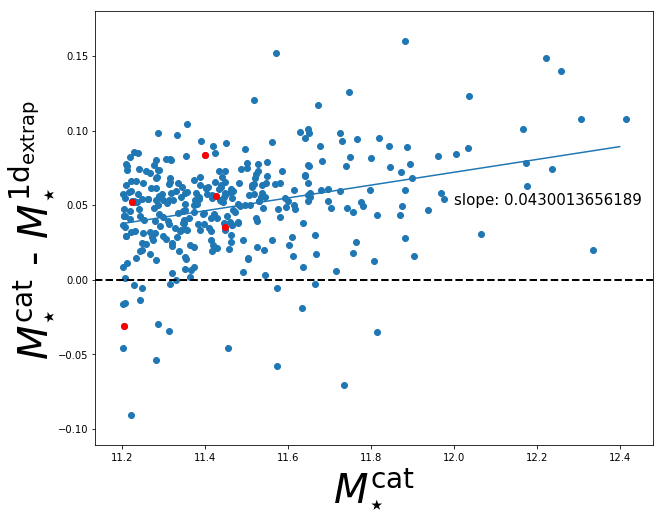

In [135]:
catalog_masses=np.array([m[0] for m in illustris_masses])
extrapolated_masses=np.array([extrapolated_1D_mass1(iso,800) for iso in illustris_isos])

#fit line
illustris_diff_cat_1dextrap_params = np.polyfit(catalog_masses, catalog_masses - extrapolated_masses , 1)
illustris_diff_cat_1dextrap_line = np.poly1d(illustris_diff_cat_1dextrap_params)
xs=np.linspace(11.2,12.4, 100)



plt.scatter(catalog_masses, catalog_masses-extrapolated_masses)
plt.scatter(random_catalog_masses, random_catalog_masses-random_extrapolated_masses, c='r')

plt.plot(xs, illustris_diff_cat_1dextrap_line(xs))
plt.text(12, 0.05,'slope: ' + str(illustris_diff_cat_1dextrap_params[0]), fontsize=15)

plt.axhline(0,c="k",linewidth=2,linestyle='--')
plt.ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{1d_{extrap}}}$ ', fontsize=40)
plt.xlabel('$M_{\star}^{\mathrm{cat}}$', fontsize=40)
plt.show

# integrate to get mass

In [18]:
#integrate over area
def power_law_r(x, m, c, c0):
    return powerlaw(x, m, c, c0)*x

In [27]:
tuple(p_fit_power) +(0,)

(-1.7123371342646292, 44717777732.362869, 0)

In [28]:
mass_int, mass_err =quad(power_law_r, 100, 500, args=tuple(p_fit_power)+(0,))
mass_int

TypeError: powerlaw() takes exactly 3 arguments (4 given)

In [12]:
mass_100 = 10**(oneD_mass(iso, 100))
mass_beyond100 = mass_int
power_law_fit_mass = np.log10(mass_100+mass_beyond100)
power_law_fit_mass

NameError: name 'mass_int' is not defined

In [160]:
iso['mag_tot'][0]/-2.5

12.241892114354755

# fit line in log-log

In [13]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

def line(x, m, b):
    return b + x*m 


x=np.log10(iso['sma_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)])
y=np.log10(iso['intens_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)])
p_fit_line, _ = curve_fit(line, x, y)
p_fit_line

array([ -1.7027239,  10.6330596])

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


NameError: name 'p_fit' is not defined

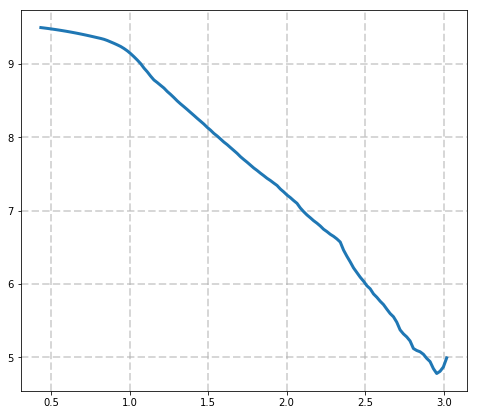

In [14]:
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

plt.plot(np.log10(iso['sma_kpc']), 
         np.log10(iso['intens_kpc']), linewidth=3.0)

x=np.linspace(0.5,3)
plt.plot(x, line(x,*p_fit), linewidth=3.0)

plt.ylabel(r'$\mu_{\star}\ (\log(M_{\star}/\mathrm{kpc}^2))$', fontsize=20)
plt.axvline(np.log10(100.0), linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.axvline(np.log10(50), linestyle='-', linewidth=3.0, alpha=0.6, c='r')
#plt.xlim(0, 300)
plt.xlabel(r'$\mathrm{\log{(SMA/kpc)}}$', fontsize=25)

### convert from log to linear space

In [18]:
def mu_function(x,m,b):
    return (10**b)*(x**(m))

def mu_r_function(x,m,b):
    return mu_function(x,m,b)*x

Text(0.5,0,u'$\\mathrm{(SMA/kpc)}}$')

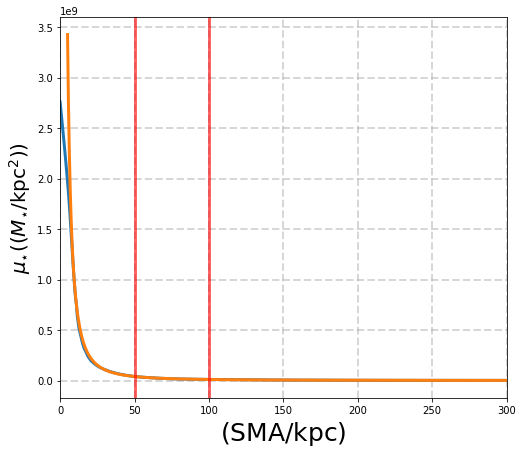

In [163]:
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

plt.plot((iso['sma_kpc']), 
         (iso['intens_kpc']), linewidth=3.0)

x=np.linspace(5,300, 500)
plt.plot(x, mu_function(x,*p_fit_line), linewidth=3.0)

plt.ylabel(r'$\mu_{\star}((M_{\star}/\mathrm{kpc}^2))$', fontsize=20)
plt.axvline(100.0, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.axvline((50), linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.xlim(0, 300)
plt.xlabel(r'$\mathrm{(SMA/kpc)}}$', fontsize=25)

In [181]:
mass_int, mass_err =quad(mu_r_function, 100, 500, args=tuple(p_fit_line))
mass_int

-1564744740017.003

In [170]:
mass_100 = 10**(oneD_mass(iso, 100))
mass_beyond100 = mass_int
linear_fit_mass = np.log10(mass_100+mass_beyond100)
linear_fit_mass

12.192790099228608

In [114]:
iso['mag_tot'][0]/-2.5

12.241892114354755

# Results 

In [111]:
galSBP_mass = iso['mag_tot'][0]/-2.5 
cat_mass=illustris_masses[0][0]
post_mass=illustris_masses[0][1]

print 'Catalog Mass: %f' %cat_mass
print 'Mass from galSPB measurement: %f' %galSBP_mass
print 'Mass from power law fit to SBP: %f' %power_law_fit_mass
print 'Mass from linear fit to SBP in log: %f' %linear_fit_mass

Catalog Mass: 12.414851
Mass from galSPB measurement: 12.241892


NameError: name 'power_law_fit_mass' is not defined

# Make function to include in get_masses.py

In [15]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

def oneD_mass(galaxy_iso, radius):
    mass=np.interp(radius,galaxy_iso['sma_kpc'], galaxy_iso['growth_ori'])
    return np.log10(mass)

def powerlaw(x, m, c, c0):
    return c0 + x**m * c
def power_law_r(x, m, c, c0):
    return powerlaw(x, m, c, c0)*x
# def powerlaw(x, m, c):
#     return x**m * c
# def power_law_r(x, m, c):
#     return powerlaw(x, m, c)*x

def extrapolated_1D_mass(iso, max_r):
    
    #fit power law between 50 and 100kpc
    x=iso['sma_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    y=iso['intens_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    p_fit_power, _ = curve_fit(powerlaw, x, y, p0=[-2,10**10])
    
    #print p_fit_power
    
    #integrate between 100 and 500kpc to get mass
    mass_beyond100, mass_err =quad(power_law_r, 100, max_r, args=tuple(p_fit_power))

    #add to galSBP mass to get total mass
    mass_100 = 10**(oneD_mass(iso, 100))
    power_law_fit_mass = np.log10(mass_100+mass_beyond100)
    
    return power_law_fit_mass

In [16]:
extrapolated_1D_mass(iso, np.inf)


TypeError: powerlaw() takes exactly 4 arguments (3 given)

Text(0.5,0,u'$\\mathrm{SMA/kpc}$')

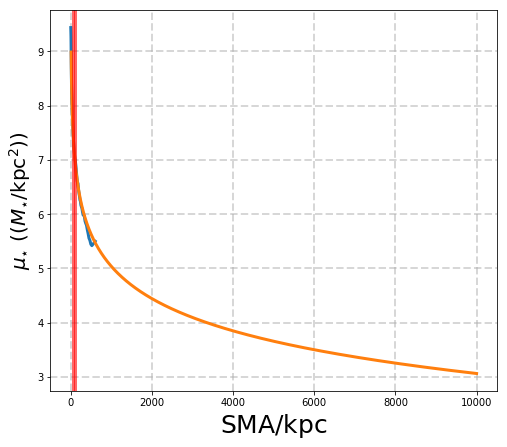

In [86]:
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

plt.plot((iso['sma_kpc']), np.log10(iso['intens_kpc']), linewidth=3.0)

x=np.linspace(10,10000,100000)
plt.plot(x, np.log10(powerlaw(x,*p_fit_power)), linewidth=3.0)

plt.ylabel(r'$\mu_{\star}\ ((M_{\star}/\mathrm{kpc}^2))$', fontsize=20)
plt.axvline(100.0, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.axvline(50, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
# plt.xlim(50, 1000)
# plt.ylim(0, 1e8)
plt.xlabel(r'$\mathrm{SMA/kpc}$', fontsize=25)

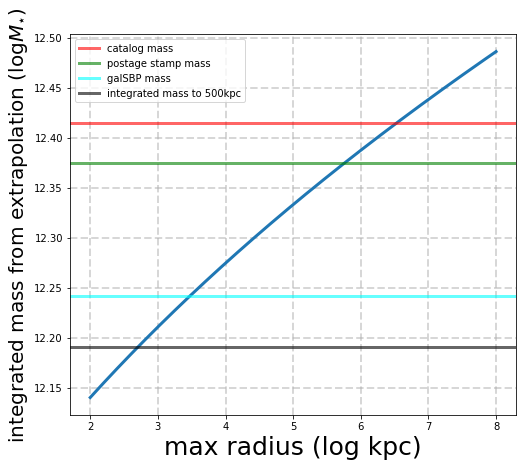

In [112]:
#mass as a function of radius
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

xs=np.logspace(2,8,10000)
masses = [extrapolated_1D_mass(iso, x) for x in xs]
plt.plot(np.log10(xs), masses, linewidth=3.0)

plt.ylabel(r'integrated mass from extrapolation $(\log M_{\star})$', fontsize=20)
plt.axhline(cat_mass, linestyle='-', linewidth=3.0, alpha=0.6, c='r', label='catalog mass')
plt.axhline(post_mass, linestyle='-', linewidth=3.0, alpha=0.6, c='g', label='postage stamp mass')
plt.axhline(galSBP_mass, linestyle='-', linewidth=3.0, alpha=0.6, c='cyan', label='galSBP mass')

plt.axhline(extrapolated_1D_mass(iso, 500), linestyle='-', linewidth=3.0, alpha=0.6, c='k', label='integrated mass to 500kpc')

plt.xlabel(r'max radius (log kpc)', fontsize=25)
plt.legend()

Text(0.5,0,u'max radius (kpc)')

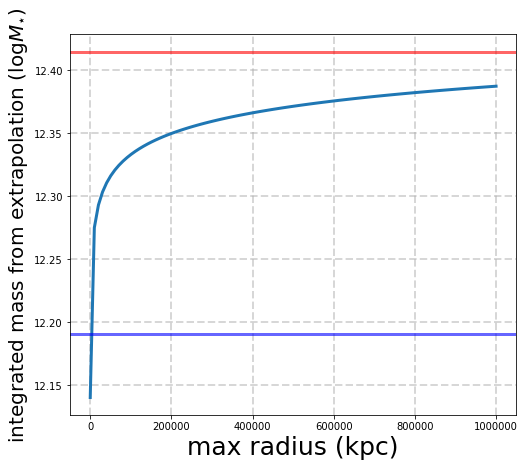

In [97]:
#mass as a function of radius
fig = plt.figure(figsize=(8, 7))

plt.grid(linewidth=2.0, linestyle='--', alpha=0.5)

xs=np.linspace(1e2,1e6,100)
masses = [extrapolated_1D_mass(iso, x) for x in xs]
plt.plot(xs, masses, linewidth=3.0)

plt.ylabel(r'integrated mass from extrapolation $(\log M_{\star})$', fontsize=20)
plt.axhline(cat_mass, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
plt.axhline(extrapolated_1D_mass(iso, 500), linestyle='-', linewidth=3.0, alpha=0.6, c='b')

plt.xlabel(r'max radius (kpc)', fontsize=25)

In [110]:
quad(power_law_r, 100, 1e16, args=tuple(p_fit_power))

(9321993558428.291, 27990.076171875)

In [10]:
iso=illustris_isos[6]

IndexError: list index out of range

In [5]:
def powerlaw(x, m, c, c0):
    return c0 + x**m * c
def power_law_r(x, m, c, c0):
    return powerlaw(x, m, c, c0)*x
# def powerlaw(x, m, c):
#     return x**m * c
# def power_law_r(x, m, c):
#     return powerlaw(x, m, c)*x


def extrapolated_1D_mass(iso, max_r):

    #fit power law between 50 and 100kpc
    x=iso['sma_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    y=iso['intens_kpc'][(iso['sma_kpc']>50) & (iso['sma_kpc']<100)]
    p_fit_power, _ = curve_fit(powerlaw, x, y, p0=[-2,10**10,0])

    #print p_fit_power

    #integrate between 100 and 500kpc to get mass
    mass_beyond100, mass_err =quad(power_law_r, 100, max_r, args=tuple(p_fit_power))

    #add to galSBP mass to get total mass
    mass_100 = 10**(oneD_mass(iso, 100))
    power_law_fit_mass = np.log10(mass_100+mass_beyond100)

    return power_law_fit_mass

In [125]:
iso['sma_kpc']

0.0
2.5476975
2.675082
2.808836
2.949278
3.0967415
3.251578
3.414157
3.5848645
3.764108
3.952313


In [8]:
extrapolated_1D_mass(iso, 500)

12.251786003816793

In [118]:
iso


sma,intens,int_err,pix_var,rms,ell,ell_err,pa,pa_err,x0,x0_err,y0,y0_err,grad,grad_err,grad_r_err,rsma,mag,mag_lerr,mag_uerr,tflux_e,tflux_c,tmag_e,tmag_c,npix_e,npix_c,a3,a3_err,b3,b3_err,a4,a4_err,b4,b4_err,ndata,nflag,niter,stop,a_big,sarea,a1,a1_err,b1,b1_err,a2,a2_err,b2,b2_err,pa_norm,sbp_ori,sbp_sub,sbp,intens_sub,intens_bkg,sbp_err,sbp_low,sbp_upp,sma_asec,rsma_asec,growth_ori,growth_sub,avg_x0,avg_y0,avg_q,avg_pa,avg_bkg,intens_cor,sbp_cor,growth_cor,rad_outer,mag_tot,mag_tot_ori,mag_tot_sub,sma_kpc,intens_kpc
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,68969150000.0,nan,nan,nan,nan,nan,nan,nan,100.0,nan,101.0,nan,-18941710000.0,nan,nan,0.0,-27.09664,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-23.6017871624,-23.6017871624,-23.6017871624,68969150000.0,0.0,nan,nan,nan,0.0,0.0,0.0,0.0,100.0,101.0,0.79,19.55,15547175.0,68953602825.0,-23.6015423858,0.0,39.9113477631,-30.6047302859,-30.6578320256,-30.6578320256,0.0,2758766000.0
0.5095395,59317600000.0,3941640000.0,20098500000.0,14211780000.0,0.21,0.09372623,19.55,14.75501,100.0,0.02533532,101.0,0.02966275,-19869330000.0,114177800000.0,5.746434,0.8448789,-26.93296,0.07465531,0.06985136,68969150000.0,68969150000.0,-27.09664,-27.09664,1.0,1.0,0.08543383,0.4930948,-0.03586035,0.2108051,-0.109079,0.627485,0.02499579,0.1463199,13,0,1.0,0.0,nan,2.0,-1312832.0,292326656.0,-9675850.0,282669312.0,-2859884.0,292449472.0,-10500768.0,282582560.0,19.55,-23.438108906,-23.438108906,-23.438108906,59317600000.0,0.0,0.0698509972215,-23.5079599033,-23.3682579088,2.5476975,1.26338863329,0.0,0.0,100.0,101.0,0.79,19.55,15547175.0,59302052825.0,-23.4378242967,0.0,39.9113477631,-30.6047302859,-30.6578320256,-30.6578320256,2.5476975,2372704000.0
0.5350164,58812490000.0,4111581000.0,20965030000.0,14824520000.0,0.21,0.095132,19.55,14.97631,100.0,0.02700107,101.0,0.03161303,-19956090000.0,113386100000.0,5.681779,0.8552474,-26.92367,0.07868728,0.0733684,68969150000.0,68969150000.0,-27.09664,-27.09664,1.0,1.0,0.09187277,0.5240318,-0.03222482,0.1884184,-0.1096323,0.623571,0.02551721,0.1476049,13,0,1.0,0.0,nan,2.0,-916701.0,306100544.0,-11642478.0,295988160.0,-2073278.0,306224480.0,-12325037.0,295892800.0,19.55,-23.4288238956,-23.4288238956,-23.4288238956,58812490000.0,0.0,0.073368113731,-23.5021920094,-23.3554557819,2.675082,1.27889318996,3884407641.35,3884407641.35,100.0,101.0,0.79,19.55,15547175.0,58796942825.0,-23.4285368416,3883380792.03,39.9113477631,-30.6047302859,-30.6578320256,-30.6578320256,2.675082,2352499600.0
0.5617672,58279870000.0,4287357000.0,21861320000.0,15458290000.0,0.21,0.09674252,19.55,15.22985,100.0,0.02883109,101.0,0.03375563,-20051010000.0,112558600000.0,5.613615,0.8657432,-26.9138,0.08296169,0.07707173,68969150000.0,68969150000.0,-27.09664,-27.09664,1.0,1.0,0.09857172,0.5552635,-0.02843071,0.1656907,-0.1101783,0.6191583,0.02605146,0.1488053,13,0,1.0,0.0,nan,2.0,-452092.4,320595456.0,-13853417.0,310004192.0,-1151187.0,320719072.0,-14366816.0,309898368.0,19.55,-23.4189464142,-23.4189464142,-23.4189464142,58279870000.0,0.0,0.0770708324386,-23.4960172466,-23.3418755818,2.808836,1.29458805547,8128191539.44,8128191539.44,100.0,101.0,0.79,19.55,15547175.0,58264322825.0,-23.4186567364,8126032586.51,39.9113477631,-30.6047302859,-30.6578320256,-30.6578320256,2.808836,2331194800.0
0.5898556,57717870000.0,4469015000.0,22787590000.0,16113260000.0,0.21,0.09860943,19.55,15.5